# Homework 2 - Soccer analytics

## Libraries

In [83]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import operator
from datetime import datetime
from matplotlib.pyplot import Rectangle
from matplotlib.patches import Arc, ConnectionPatch
import seaborn as sns
from scipy import stats
import time
from datetime import date

## [RQ1] Who wants to be a Champion?

The goal of this exercise is to find the best players (and the worst ones) that tried most passes while succeding (or failing).

The value stored in a row (match result) that contains match infos is stored as a string, which needs to be parsed or manipulated in some way to extract relevant information.
We used a division of string by dividing character.
First we divide the teams from the score, then again with a different character for the individual values.


In [25]:
def get_score_from_label(string):
    string = str(string) # Make sure it's a string, altough not really necessary
    tokens = re.split('; |,', string) # Split by characters
    teams_raw = re.split('-', tokens[0])#Tokens[0] is the teams playing
    teams = list()
    for t in teams_raw:
        teams.extend([str(t.strip())])#We want leading and trailing whitespaces removed
    
    score_raw = re.split('-', tokens[1])# Getting individual scores
    score = list()
    for s in score_raw:
        score.extend([int(s.strip())])# Whitespaces removed
        
    return teams, score

Here we are creating a dictionary to contain, for each team (the team id is the key), the performances for each week. 
Score = 3? Match won. Score = 1? A tie. Score = 0? Match lost. 
Each week will have a corresponding index in the 'performance array',with an associated value in {3,1,0}. 

In [26]:
def get_dict_results(nation):
    ds_path = './DS/matches_'+nation+'.json'
    matches_ds = pd.read_json(ds_path)

    results = {}
    
    for i in range(len(matches_ds)):
        label = matches_ds['label'][i]
        week = matches_ds['gameweek'][i] # The gameweek goes from 1 to 38

        teams, score = get_score_from_label(label)#Getting the match info
        
        # Since there are 2 teams for each match, we are also registering
        # 2 teams's information at a time.
        team1 = teams[0]
        team2 = teams[1]
        
        score1 = score[0]        
        score2 = score[1]
        
        # We need to check if a team is in the keys of the dictionary
        # i.e. it has already a performance array that might contain data
        if team1 not in results.keys():
            results[team1] = np.zeros(38) # The 'performance array'
            
        if team2 not in results.keys():
            results[team2] = np.zeros(38)
        
        # Here we are registering the score for a given week
        # Side note: since the game week in the dataset starts from 1, a week-1 will 
        # give us the correct associated week in the performance array.
        if score1 > score2:
            # Winner is team 1
            results[team1][week-1] = 3
            results[team2][week-1] = 0
            
        elif score1 < score2: 
            # Winner is team 2
            results[team1][week-1] = 0
            results[team2][week-1] = 3
        else:
            # It's a tie
            results[team1][week-1] = 1
            results[team2][week-1] = 1
            
    return results

For calculating the max streak of wins, we check for consecutive occurrences of 3s, so when we find another value the streak is saved and the counter reset.

In [27]:
def max_streak(weekly_point):
    streaks = []
    current_streak = 0 # This acts as the counter
    for i in weekly_point:    
        if i == 3:
            current_streak +=1
        else:
            
            if current_streak > 0:
                streaks.extend([current_streak])
            current_streak = 0
            
    # Python sorts in ascending order. For ease of use, we want it in reversed
    # order, which is descending order
    streaks.sort()
    streaks.reverse()
    return streaks

For calculating the min streak of matches lost, we check for consecutive occurrences of 0s, so when we find another value the streak is saved and the counter reset.

In [28]:
def min_streak(weekly_point):
    streaks = []
    current_streak = 0
    for i in weekly_point:    
        if i == 0:
            current_streak +=1
        else:
            
            if current_streak > 0:
                streaks.extend([current_streak])
            current_streak = 0
            
    streaks.sort()
    streaks.reverse()
    return streaks


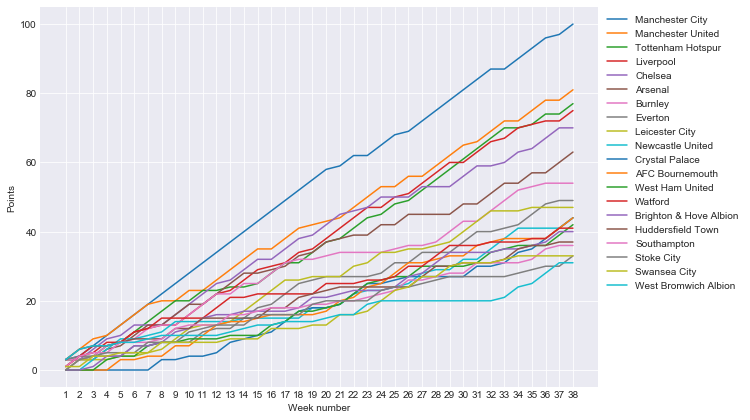

In [29]:
# First load the relevant datasets
players_ds = pd.read_json('./DS/players.json')
coaches_ds = pd.read_json('./DS/coaches.json')
teams_ds = pd.read_json('./DS/teams.json')
nations = ['England'] # It's a list so other nations can be added easily

res = {}
teams_streaks = []
teams_streaks_loss = []

for nat in nations:
    tmp_res = get_dict_results(nat)
    res.update(tmp_res)

# Since the figure to plot in will be used after in a loop, 
# we declare it before said loop. Also setting the style.
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10,7))

# Sorting now so the legend in the plot is ordered by team performance
team_scores = [[key, res[key]] for key in res.keys()]
team_scores.sort(key=lambda r : sum(r[1]))
team_scores.reverse()

for team in team_scores: # A key is a team id
    team_name = team[0]
    team_data = team[1] # Get the season performance array

    week_names = list(range(1, 39))

    points = np.zeros(38) # Total points
    for i in range(0, 38):
        points[i] = sum(team_data[0:i+1]) # For the line plot, we want the total number of points until the nth week


    # Here calculate the performance of the team using its 'performance array'
    team_streak = max_streak(team_data)
    team_streak_loss= min_streak(team_data)

    # Save the streaks for later, also save the key for later name retrieval
    teams_streaks.extend([[team_name, team_streak]])
    teams_streaks_loss.extend([[team_name, team_streak_loss]])

    # Add line to the plot
    plt.plot(week_names, points, label=team_name) #Without calling plt.show() immediately after, the lines will overlap

plt.legend(bbox_to_anchor=(1, 1)) # Make a legend and put it on the right
plt.xticks(week_names) # Give the names for each week (tick is an increment, so a new week)
plt.xlabel('Week number')
plt.ylabel('Points')
plt.show()

Here starts the second part of the exercise. We want to know which are the teams that had the largest win/loss streak and the second after.

In [30]:
# Since the sorting happens by the first value of the (ordered) performance array, 
# we have to use this lambda to tell the sorting function to use said value as the key for ordering.
teams_streaks.sort(key = lambda teams_streaks: teams_streaks[1][0])
teams_streaks_loss.sort(key = lambda teams_streaks_loss: teams_streaks_loss[1][0])

# Go from ascending order from descending order. This way we can easily get the max value
teams_streaks.reverse()
teams_streaks_loss.reverse()

first_worst = teams_streaks_loss[0][0]
second_worst = teams_streaks_loss[1][0]

first_best = teams_streaks[0][0]
second_best = teams_streaks[1][0]

print() # Just adding a new line after the plot
print('Best performing team: ', first_best)
print('Second best performing team: ', second_best)
print('----')
print('Worst performing team: ', first_worst)
print('Second worst performing team: ', second_worst)


Best performing team:  Manchester City
Second best performing team:  Tottenham Hotspur
----
Worst performing team:  West Bromwich Albion
Second worst performing team:  Crystal Palace


## [RQ2] Is there a home-field advantage?

In this question we are looking for find out whether playing at home stadium can affect performance of a team or not.
In this regard, we calculated WIN, LOSE and DRAW matches for 5 teams and formed a table for showing results. 
After that, we implemented a Chi square test for finding out whether different results of teams at home and away stadiums are meaningful or not.

In [37]:
dfmatches = pd.read_json('./DS/matches_England.json',encoding='utf-8')

In [38]:
#Distinguishing HOME,AWAY teams for each match and result of match.

hometeams = []
homeresult = []
awayteams = []
awayresult = []

for index,row in dfmatches.iterrows():
    a,b,c,d = row['label'].replace('-',',').split(',')
    hometeams.append(a)
    awayteams.append(b)
    if int(c)>int(d):
        homeresult.append('win')
        awayresult.append('lose')
    elif int(c)<int(d):
        awayresult.append('win')
        homeresult.append('lose')
    else:
        awayresult.append('draw')
        homeresult.append('draw')

In [39]:
#Adding needed columns for our test to the dataframe of Mtaches. 

dfmatches['hometeams'] = hometeams
dfmatches['awayteams'] = awayteams
dfmatches['homeresult'] = homeresult
dfmatches['awayresult'] = awayresult

In [40]:
dfmatches.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId,hometeams,awayteams,homeresult,awayresult
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089,Burnley,AFC Bournemouth,lose,win
1,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",Selhurst Park,1628,2500090,Crystal Palace,West Bromwich Albion,win,lose
2,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",The John Smith's Stadium,1609,2500091,Huddersfield Town,Arsenal,lose,win
3,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",Anfield,1612,2500092,Liverpool,Brighton & Hove Albion,win,lose
4,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",Old Trafford,1611,2500093,Manchester United,Watford,win,lose


In [41]:
#collecting teams playing in PL of England.

print(set(dfmatches['hometeams']))

{'Crystal Palace ', 'Southampton ', 'Watford ', 'Brighton & Hove Albion ', 'Tottenham Hotspur ', 'Newcastle United ', 'West Bromwich Albion ', 'Stoke City ', 'Huddersfield Town ', 'West Ham United ', 'Arsenal ', 'Manchester City ', 'AFC Bournemouth ', 'Manchester United ', 'Leicester City ', 'Liverpool ', 'Everton ', 'Chelsea ', 'Swansea City ', 'Burnley '}


In [42]:
#Selecting 5 teams for doing the test.

selected_teams = ['Manchester United', 'Watford', 'Liverpool', 'Crystal Palace', 'Chelsea']
# results = dict.fromkeys(selected_teams,[0]*6)
results=np.zeros((5,6), dtype=int)

In [43]:
#calculating No. of WIN,LOSE and DRAW of selected teams in the season.

for index,row in dfmatches.iterrows():
    for i in range(0,5):
        
        if (str(dfmatches['hometeams'][index]).strip() == selected_teams[i]):
            if (str(dfmatches['homeresult'][index]).strip() == 'win'):
                results[i][0] +=1
            if (str(dfmatches['homeresult'][index]).strip() == 'draw'):
                results[i][1] +=1
            if (str(dfmatches['homeresult'][index]).strip() == 'lose'):
                results[i][2] +=1
        if (str(dfmatches['awayteams'][index]).strip() == selected_teams[i]):
            if (str(dfmatches['awayresult'][index]).strip() == 'win'):
                results[i][3] +=1
            if (str(dfmatches['awayresult'][index]).strip() == 'draw'):
                results[i][4] +=1
            if (str(dfmatches['awayresult'][index]).strip() == 'lose'):
                results[i][5] +=1

In [44]:
print(results)

[[15  2  2 10  4  5]
 [ 7  6  6  4  2 13]
 [12  7  0  9  5  5]
 [ 7  5  7  4  6  9]
 [11  4  4 10  3  6]]


In [21]:
#Building Contingency table for selected teams.

contin_table = pd.DataFrame(results, columns = ['homewin', 'homedraw', 'homelose', 'awaywin', 'awaydraw', 'awaylose'], index=selected_teams)
contin_table

,homewin,homedraw,homelose,awaywin,awaydraw,awaylose
Manchester United,15,2,2,10,4,5
Watford,7,6,6,4,2,13
Liverpool,12,7,0,9,5,5
Crystal Palace,7,5,7,4,6,9
Chelsea,11,4,4,10,3,6


In [45]:
#Doing Chi square test.

stats.chi2_contingency(contin_table)

(30.261197432250068,
 0.0657304343872097,
 20,
 array([[10.4,  4.8,  3.8,  7.4,  4. ,  7.6],
        [10.4,  4.8,  3.8,  7.4,  4. ,  7.6],
        [10.4,  4.8,  3.8,  7.4,  4. ,  7.6],
        [10.4,  4.8,  3.8,  7.4,  4. ,  7.6],
        [10.4,  4.8,  3.8,  7.4,  4. ,  7.6]]))

###### Hypothsis Test - Chi Square Test
 

H0 is the hypothesis that there is no differnece between result of a match for a team if that team is on home or away side.
H1 is the hypothesis that there is differnece in a team's performance when that is on home or away side.
Rejecting threshold for doing this test is supposed to be 0.05.
Selected teams for analysis are as follow: {Manchester United, Watford, Liverpool, Crystal Palace, Chelsea}


###### Result

 As obtained P-value (0.06) is greater than 0.05, so we can not reject H0 . so by this observations we can say H0 is True.

## [RQ3] Which teams have the youngest coaches? 

The point of this exercise is to show which teams, in this case the ones in the premier league, have the youngest coaches.

Then we have to rank them based on this. For the second part, it's showing the age distribution.
This function has been made to create a dictionary where the team is the key, and the birthdate of the youngest coach is the value. 

In [46]:
def coaches_dictionary(coaches):
    coach  = {}
    
    # We iterate over the coaches dataframe
    for i in range(len(coaches)):
        key = coaches['currentTeamId'][i] # We get the key for the dictionary
        if key != 0: # Side note: since more coaches in the df have the same team id = 0
                     # we did not make assumptions on which team they belonged.
            new_birth_date = coaches['birthDate'][i] # Get the birthdate in YYYY-mm-dd format
            if key not in coach.keys(): # if the team is not registered in the dictionary
                coach[key] = new_birth_date # add the key and put the first found birthdate
            else:
                #`Otherwise compare the newly found birthdate with the one already 'registered'
                found_birth_date = coach[key]            
                new_date = time.strptime(new_birth_date, "%Y-%m-%d")
                found_date = time.strptime(found_birth_date, "%Y-%m-%d")
                
                if new_date < found_date: # Eventually, if the newly found is more recent, delete the old one and put the new one
                    coach[key] = new_birth_date
    # Side note: A dictionary was used for easy and fast access to a value by id
    return coach

This one is basically a support function, so we get easily the official team name with the relative team id.

In [47]:
def team_id_name_list(df):
    
    team_names = list()
    
    for i in range(len(df)): # Iterate over the dataframe
        
        # Get team data and add it to the list
        t_official_name = str(df['officialName'][i])
        t_id = int(df['wyId'][i])
                
        team_names.append([t_id, t_official_name])
        
    return team_names

Another support function. It's supposed to take the dictionary of {team id: youngest coach birthdate} and perform a 'join' on the team id, so we get the team name and the youngest coach's age in the same data structure for easy reading when data is printed.

In [48]:
def team_birth_list(d,lst):
    team_birth = []
    for key in d.keys():
        for item in lst:
            if key == item[0]:
                team_name = item[1] 
                age = get_age(d[key])
                team_birth.append([team_name,age])
    return team_birth

Support function to easily calculate the age given a birthdate formatted as a string like YYYY-mm-dd.

In [49]:
def get_age(birthdate):
    new_date = birthdate.split('-')    
    new_date = list(map(int, new_date))
    born = date(new_date[0], new_date[1], new_date[2])
    today = date.today() 
    days_in_year = 365.2425 # Must keep count of the extra day in a year
    age = int((today - born).days / days_in_year)
    
    return age

In [54]:
# Load the needed datasets
coaches = pd.read_json("./DS/coaches.json")
teams = pd.read_json("./DS/teams.json")
matches = pd.read_json('./DS/matches_England.json')
# Here we are filtering out the teams that are not from England and 
# of course, the national teams which do not play in the Premier League.
teams = teams[teams.area.apply(lambda x : x['name'] == 'England')]
teams = teams[teams.type == 'club']
teams = teams.reset_index(drop=True) 
# resetting the index to avoid gaps while iterating over dataset


d = coaches_dictionary(coaches)
t_id_names = team_id_name_list(teams)
team_birth = team_birth_list(d, t_id_names)    
# Now we have a list like [[team_name, youngest coach birthdate]]

team_birth.sort(key=lambda r : r[1]) 
# Sort by age, ascending order


# Printing the ranking of the youngest coaches
for i in range(len(team_birth[:10])):
    add_str = ''

    if i == 0:
        add_str = '| [Has the youngest coach]'
    else:
        add_str = ''

    print('(%d) - %s | Age %d %s' % (i+1, team_birth[i][0], team_birth[i][1], add_str))
# Plotting age distribution

(1) - AFC Bournemouth | Age 41 | [Has the youngest coach]
(2) - Everton FC | Age 42 
(3) - Arsenal FC | Age 47 
(4) - Tottenham Hotspur FC | Age 47 
(5) - Burnley FC | Age 48 
(6) - Manchester City FC | Age 48 
(7) - Watford FC | Age 49 
(8) - Southampton FC | Age 52 
(9) - Liverpool FC | Age 52 
(10) - Newcastle United FC | Age 59 


Since before we eliminated an older coach if we found a younger one, we need to retrieve again the data this considering all the coaches that participated in the premier league. 
This time though, just to be sure we are getting all of them, we consider the matches of the premier league: each match has the coaches id that participated.

[Text(0, 0, 'Premier League')]

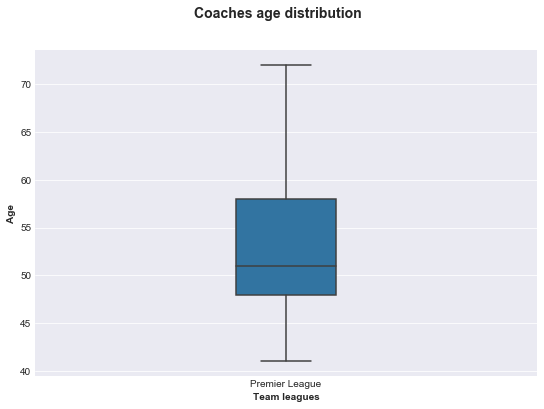

In [55]:
# First we get the coach ids
coaches_ids = []
for i in range(len(matches)):
    teams_data = matches['teamsData'][i]
    coach_id = [teams_data[key]['coachId'] for key in teams_data.keys()]
    coaches_ids.extend(coach_id)

# Then we get the birthdates from the coaches dataset where wyId == coach_id
coaches_ids = list(dict.fromkeys(coaches_ids))
age_distribution = []
for i in range(len(coaches)):
    coach_id = coaches['wyId'][i]
    if coach_id in coaches_ids:
        coach_birthday = coaches['birthDate'][i]
        age = get_age(coach_birthday)
        age_distribution.append(age)

''' Here we are plotting the distribution using a boxplot '''
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
sns.set_style("darkgrid")
ax.set_xlabel('Team leagues', fontweight='bold')
ax.set_ylabel('Age', fontweight='bold')
fig.suptitle('Coaches age distribution', fontsize=14, fontweight='bold')

b = sns.boxplot([age_distribution], ax=ax, orient='v', width=0.2)
b.set_xticklabels(['Premier League'])

## [RQ4] Find the top 10 players with the highest ratio between completed passes and attempted passes.

In [56]:
# First load the relevant datasets
event_ds = pd.read_json('./DS/events_England.json')
player_ds = pd.read_json('./DS/players.json')

The threshold is used to make sure that we have avoided meaningless results!
For making the threshold we calculated the mean of all passes that all players have made and just consider the players that have more passes than that number. so we need the number of passes that each player has made, by using group by over playerId and knowing that the passes have the subIds between 80-86, we count the number of passes. but not all these passes were successful! we need to detach the ones that were successful.
Then at the end we calculated the ratio of successful passes that player had. at the end we sorted and listed the 10 players from premier league and printed them out with their short names and ratios.

In [58]:
# each player has howmany passes made and calculate the mean for all players
allkind_passes = event_ds[event_ds["subEventId"].isin([i for i in range(80,87)])].groupby(["playerId"]).count()
allkind_passes.reset_index(drop=False,inplace=True)
threshold = allkind_passes["eventId"].mean() # threshold

# creating a dictionary to contain, for each player (the playerId is the key), the successful passes.
successful_player = {} 
for i in range(len(event_ds)): # check for all kind of passes which has been successful
    event_type = event_ds['subEventId'][i]  

    if event_type in range(80,87): # the range of the subId of all passes
        tags = event_ds['tags'][i] # the column that contains tag 1801 
        tag_values = [t['id'] for t in tags]
        player_id = event_ds['playerId'][i] # check for each player

        if player_id not in successful_player.keys():
            successful_player[player_id] = [0, 0]

        if 1801 in tag_values: # a completed pass has tag 1801
            # Successful
            successful_player[player_id][0] += 1
        else:
            # failed
            successful_player[player_id][1] += 1


# calculation of the ratio and appending it to a list with players shortnames and wyId
Player_list = []
for i in range(len(player_ds)):
    player_id = player_ds['wyId'][i] # each playerId
    short_name = player_ds['shortName'][i] # the player short name

    player_data = allkind_passes.loc[allkind_passes.playerId == player_id , "tags"]  
    if player_data is not None and len(player_data) > 0:      
        number_passes = player_data.tolist()[0]

        #using the threshold
        if number_passes >= threshold: 
            if player_id in successful_player.keys():
                success = successful_player[player_id][0]
                fail = successful_player[player_id][1]

                ratio = 0 
                if fail != 0: 
                    ratio = success / (success + fail)
                Player_list.append([short_name, ratio])
                
#reversing the list and sorting it (Go from ascending order from descending order)to find the 10 first players with high ratio     
Player_list.sort(key=operator.itemgetter(1))
Player_list.reverse()

# printing the list with numbers from 1 to 10
for i in range(len(Player_list[:10])):
    print('(%d) - %s' % (i+1, Player_list[i]))

(1) - ['J. Stones', 0.9759136212624585]
(2) - ['F. Delph', 0.9450757575757576]
(3) - ['V. Kompany', 0.9432063263838965]
(4) - ['A. Christensen', 0.9402173913043478]
(5) - ['P. Jones', 0.9385052034058656]
(6) - ['N. Otamendi', 0.9375843454790823]
(7) - ['Mohamed Elneny', 0.9364508393285371]
(8) - ['\\u0130. G\\u00fcndo\\u011fan', 0.9355555555555556]
(9) - ['V. Lindel\\u00f6f', 0.9355281207133059]
(10) - ['M. Demb\\u00e9l\\u00e9', 0.9326007326007326]


## [RQ5] Does being a tall player mean winning more air duels?

Here we are trying to see if there's a correlation between the height of a player and the number of air duels won.

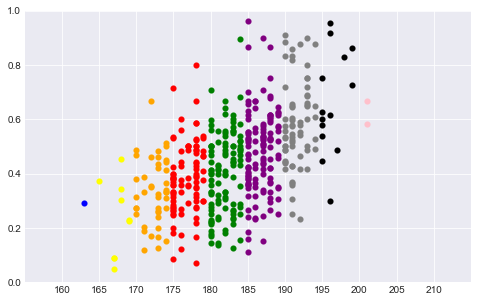

In [60]:
# Loading the events dataset for the premier league, here are stored events 
# such as air duels and their outcome (won, lost, ...)
event_ds = pd.read_json('./DS/events_England.json')
player_performance = {}

for i in range(len(event_ds)):
    event_type = event_ds['subEventName'][i] # First we get the specific name of the event

    if event_type == 'Air duel': # We are only interested if the event is an air duel
        tags = event_ds['tags'][i] # The tags field contains information about the outcome
        tag_values = [t['id'] for t in tags] # but first we have to extract the individual values
        player_id = event_ds['playerId'][i]
        # The player id will be used as the key for the dictionary
        # It will be used later to join, on the player id, to make the height:ratio list
        if player_id not in player_performance.keys():
            # the performance array for a player has arbitrary indexes:
            # [0] is for won air duels, [1] is for lost ones 
            player_performance[player_id] = [0, 0] 

        # The 1801 and 703 tag values signal a successful outcome for the event
        if 1801 in tag_values and 703 in tag_values:
            # Successful
            player_performance[player_id][0] += 1
        else:
            # Attempted and failed
            player_performance[player_id][1] += 1


# Build height-ratio table
player_ds = pd.read_json('./DS/players.json')
plot_list = []

for i in range(len(player_ds)):
    player_id = player_ds['wyId'][i] # Get the player id
    height = player_ds['height'][i] # Get the player's height

    if player_id in player_performance.keys(): # If we have a player id, then there should be the performance array

        # Calculate the ratio
        successful = player_performance[player_id][0]
        failed = player_performance[player_id][1]    
        ratio = 0 # We suppose the ratio is 0 
        if failed != 0: # Must avoid division by 0
            ratio = successful / (successful + failed)

        if ratio != 0: # Here is just a threshold, if this line gets deleted even the player with no successful 
                       # air duels will be plotted. 
            plot_list.append([height, ratio])

# Plotting
plot_list.sort(key=lambda x : x[0]) # We want the players data sorted by height, ascending order
height_list = [p[0] for p in plot_list] # List remains ordered, no need to worry if we split 'plot_list'
ratio_list = [p[1] for p in plot_list]

plt.figure(figsize=(8,5))
plt.xlabel = 'height'
plt.ylabel = 's/f ratio'
colors = ['blue', 'yellow', 'orange', 'red', 'green', 'purple', 'grey', 'black', 'pink']

height_interval = 5 # This is an arbitrary value to split the height values in 5cm increments

# Rounding the min_height to the nearest lower multiple of 10: doing so allows for a nice visualization
min_height = min(height_list) - (min(height_list)%10) 
max_height = max(height_list) + (10 - max(height_list)%10) # Round to the nearest greater multiple of 10
plt.xticks(range(min_height, max_height+1, 5)) # For visibility, add ticks in 5cm increments between min height and max height

for i in range(len(plot_list)):
    r = plot_list[i]

    # The way the colors is assigned seems complicated because not only we want a color from the colors list,
    # but if the colors are not enough (too many 5cm increments) they will start being assigned from the first one (rotation)
    # Also we don't want 160 to be an index, so we normalize it to be in the [0, len of color list) range.
    plt.scatter(r[0], r[1], lw=0.1, c = colors[int((r[0] - min_height)//height_interval % len(colors))])

# We want the axis to start 5cm before the min height value rounded to the lowest multiple 10, 
# and the other max axis to be 5cm after the nearest greater multiple of 10
plt.axis([min_height-5, max_height+5, 0, 1])

plt.show()

It really looks like there is a positive correlation, between the height and the success ratio in air duels! 

## [RQ6] Free your mind!

The goal of this exercise is to show a new interesting result about the dataset that we found. it was interesting for us to analize which nationalities have better players!(to be more specific, players from which countries have higher ratio of successful passes. we had the ratio from RQ4 and now we had to use the birth Area column in player_ds which was a dictionary and use the first value of it(the country of birth's name)).
At the end we made a plot which shows the name of the cpuntries and the number of players with high ratio.

In [62]:
event_ds = pd.read_json('./DS/events_England.json')
player_ds = pd.read_json('./DS/players.json')

# each player has howmany passes made and calculate the mean for all players
all_passes = event_ds[event_ds["subEventId"].isin([i for i in range(80,87)])].groupby(["playerId"]).count()
all_passes.reset_index(drop=False,inplace=True)
threshold = all_passes["eventId"].mean()

# creating a dictionary to contain, for each player (the playerId is the key), the successful passes.
passes_successful = {}
for i in range(len(event_ds)): # check for all kind of passes which has been successful
    event_type = event_ds['subEventId'][i]
    if event_type in range(80,87): # the range of the subId of all passes
        tags = event_ds['tags'][i] # the column that contains tag 1801 
        tag_values = [t['id'] for t in tags]
        player_id = event_ds['playerId'][i]

        if player_id not in passes_successful.keys():
            passes_successful[player_id] = [0, 0]

        if 1801 in tag_values: # a completed pass has tag 1801
            # Success
            passes_successful[player_id][0] += 1
        else:
            # failure
            passes_successful[player_id][1] += 1


# calculation of the ratio and appending it to a list with players shortnames and wyId
# adding the nationality of players to the list
Player_list = []
dic = dict(player_ds["birthArea"]) # the column that has the players nationality
for i in range(len(player_ds)):
    player_id = player_ds['wyId'][i]
    short_name = player_ds['shortName'][i] # players short names
    try: # for avoidig errors we used try except
        v = dic.get(i).get("name")
    except:
        pass

    # for having number of passes that each player had
    player_data = all_passes.loc[all_passes.playerId == player_id , "tags"]
    if player_data is not None and len(player_data) > 0:      
        number_passes = player_data.tolist()[0]

        #calculating the ratio
        #using the threshold so if a player has less passes than the threshold we are not going to consider that player
        if number_passes >= threshold: 
            if player_id in passes_successful.keys():
                successful = passes_successful[player_id][0]
                failed = passes_successful[player_id][1]

                ratio = 0 
                if failed != 0:
                    ratio = successful / (successful + failed)
                Player_list.append([short_name, ratio, v])

#reversing the list and sorting it (Go from ascending order from descending order)to find the 10 first players with high ratio     
Player_list.sort(key=operator.itemgetter(1))
Player_list.reverse()

#printing the list of all players short names and their ratio and their nationality
for i in range(len(Player_list)):
    print('(%d) - %s' % (i+1, Player_list[i]))
    

(1) - ['J. Stones', 0.9759136212624585, 'England']
(2) - ['F. Delph', 0.9450757575757576, 'England']
(3) - ['V. Kompany', 0.9432063263838965, 'Belgium']
(4) - ['A. Christensen', 0.9402173913043478, 'Denmark']
(5) - ['P. Jones', 0.9385052034058656, 'England']
(6) - ['N. Otamendi', 0.9375843454790823, 'Argentina']
(7) - ['Mohamed Elneny', 0.9364508393285371, 'Egypt']
(8) - ['\\u0130. G\\u00fcndo\\u011fan', 0.9355555555555556, 'Germany']
(9) - ['V. Lindel\\u00f6f', 0.9355281207133059, 'Sweden']
(10) - ['M. Demb\\u00e9l\\u00e9', 0.9326007326007326, 'Belgium']
(11) - ['Ederson', 0.9324487334137516, 'Brazil']
(12) - ['R. Klavan', 0.9309734513274336, 'Estonia']
(13) - ['O. Zinchenko', 0.9309309309309309, 'Ukraine']
(14) - ['A. Laporte', 0.9255455712451861, 'France']
(15) - ['Fernandinho', 0.9180154820548909, 'Brazil']
(16) - ['D. Lovren', 0.9163253364540667, 'Croatia']
(17) - ['J. Matip', 0.9162967660114141, 'Germany']
(18) - ['L. Koscielny', 0.9130173965206959, 'France']
(19) - ['C. Smalling

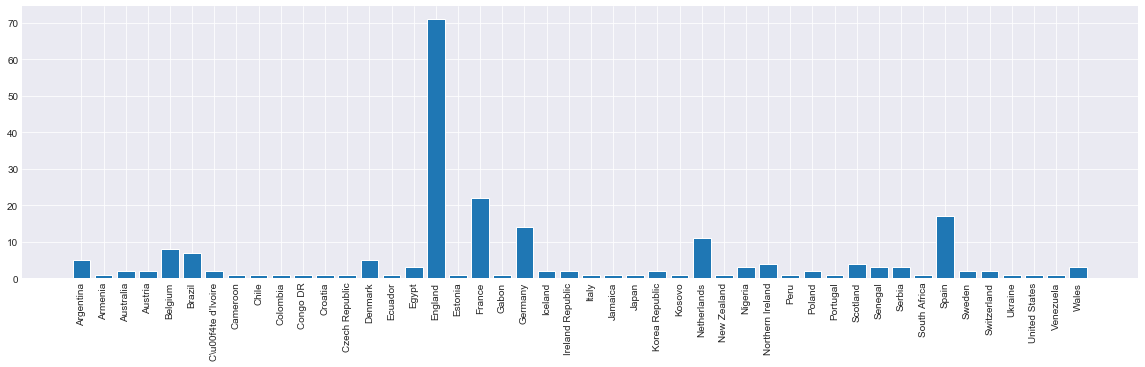

In [63]:
#to make a plot to show each country has howmany players with high ratio
plt.figure(figsize=(20,5)) # stretching the plot(resizing it)
# this line will make a dataframe from the player_list with 3 columns named like below and group them by the nationality and count how many players with same nationality exist
x = pd.DataFrame(Player_list, columns=['name', 'ratio', 'nationality']).groupby('nationality').count()[['name']]
plt.bar(height=x['name'], x = x.index) # making a bar plot
plt.xticks(x.index, rotation = 'vertical') # for rotating the name of the countries 45' for better readability
plt.show() #showing the plot
# from the plot it is obvious that english players are more likely to have high ratio for successful passes.


## [CRQ1] What are the time slots of the match with more goals? 

In this exercise, the main goal is to analyze different matches by dividing each match in different time intervals of 9 minutes each. 
    
    I.   Make a barplot with the absolute frequency of goals in all the time slots.
    II.  Find the top 10 teams that score the most in the interval "81-90".
    III. Show if there are players that were able to score at least one goal in 8 different intervals.
    The first time interval will be the one [0-9), so [0-8]. 
    We are supposing that when each half time ends, it's at the 45 and 90 minute
    mark. So when, for example, a goal is scored at the 45th minute, it's score
    in the extra time given (45+).

###### I.

In [64]:
print("Loading datasets...")
events = pd.read_json('./DS/events_England.json')
matches = pd.read_json('./DS/matches_England.json')
teams = pd.read_json('./DS/teams.json')
players = pd.read_json('./DS/players.json')
print("Datasets loaded.")

# Here we are preparing to make a new dataframe that will contain only useful information
# for doing this exercise
cols = ['playerId', 'matchPeriod','matchId','teamId', 'eventSec', 'eventInterval']
goals_df = pd.DataFrame(columns=cols)

Loading datasets...
Datasets loaded.


In [66]:
for i in range(len(events)):
        tags = [t['id'] for t in events['tags'][i]]
        
        # A goal(101) or an autogoal(102) might be scored. Either way, it's a goal.
        if 101 in tags or 102 in tags:
            player_id = events['playerId'][i]
            match_period = events['matchPeriod'][i]
            match_id = events['matchId'][i]
            team_id = events['teamId'][i]
            event_sec = events['eventSec'][i] # This for now is just a raw string containing the seconds in which the event happened
            
            row = [{'playerId':player_id,
                    'matchPeriod':match_period,
                    'matchId':match_id,
                    'teamId':team_id,
                    'eventSec':event_sec,
                    'eventInterval': -1}] # The interval # can be for now set to a default value (-1) which is meaningless (easier debugging).
            
            # Here is the new row for the dataframe ready to be inserted
            new_df_row = pd.DataFrame(row, index=[len(goals_df)]) # Create
            goals_df = goals_df.append(new_df_row, ignore_index=True)

In [67]:
# Using the new dataset (goals_df) we can start to put each event in its time interval
for i in range(len(goals_df)):
    seconds = goals_df['eventSec'][i]
    period = goals_df['matchPeriod'][i]

    minutes = seconds // 60.0 # From seconds to minutes using an integer resulting division

    if period == '1H':
        if minutes < 45: # If it happened before the beginning of the 45th minute, it's not extra time.
            interval = minutes // 9 # 1H with no extra time, dividing by nine will give the interval index (IMPORTANT!)
        else:
            interval = 5 # Extra time of the 1H, it's going to be assigned to an arbitrary slot
    elif period == '2H':
        if minutes < 45:
            interval = 6 + ( minutes // 9) # 2H with no extra time
        else:
            interval = 11 # Extra time of the 2H

    goals_df.at[i, 'eventInterval'] = interval

In [68]:
# Let's start preparing the absolute frequencies
fr_interval = np.zeros(12) # Frequencies interval
for i in range(len(goals_df)):       
    interval_index = int(goals_df['eventInterval'][i]) # Conversion necessary: fetching from dataset directly gives you a float
    fr_interval[interval_index] += 1 # We can access directly by index the frequency intervals array

In [69]:
# Here we are preparing the label names for each interval
x_labels = []
for i in range(0, 11):
    label = ''
    start_minute = 9 * i
    end_minute = start_minute + 9

    if start_minute == 45 or start_minute == 90:
        x_labels.append(str('%d+' % start_minute))

    if start_minute != 90:
        x_labels.append(str('[%d-%d)' % (start_minute, end_minute)))

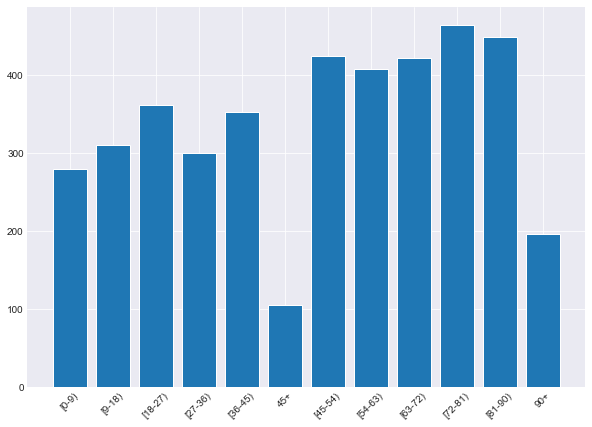

In [70]:
# Plotting the goal frequencies for each interval
plt.figure(figsize=(10,7))
x = np.arange(12)
plt.xticks(x, x_labels, rotation=45) # Each 'tick' is a time interval
plt.bar(x, fr_interval) # Drawing the actual absolute frequencies
plt.show()

###### II.

In [71]:
# For each team, find the 10 that scored the most in the 81-90 min range 
# which is interval number 11 (index 10).

print()
# Just a new line
# The team ids will be the keys
team_scores_81_90 = {}

In [72]:
for i in range(len(goals_df)):


    # First we analyze the goal interval, if it's not in the [81-90)
    # don't even bother fetching the teamId.
    interval = goals_df['eventInterval'][i]
    if interval == 10:
        team_id = goals_df['teamId'][i]
        # If the team is not in the dictionary, initialize it with the initial value of 0
        if team_id not in team_scores_81_90.keys():
            team_scores_81_90[team_id] = 0
        team_scores_81_90[team_id] += 1

In [73]:
# Make a DataFrame so we can easily merge with the teams dataset
team_scores_81_90 = pd.DataFrame(list(team_scores_81_90.items()), columns=['wyId', 'Scores8190'])
team_scores_81_90 = team_scores_81_90.merge(teams, on='wyId', how='inner')

In [74]:
# Sort the values by their scores
team_scores_81_90 = team_scores_81_90.sort_values(by='Scores8190', ascending=False)

In [75]:
# Reset the index now that the rows are sorted by score, printing will be correct (otherwise it will be like they're unordered)
team_scores_81_90 = team_scores_81_90.reset_index(drop=True)

In [76]:
# Print the rank of the ten teams that scored most goals in the [81-90) interval
for i in range(10):
    team_name = team_scores_81_90['officialName'][i]
    team_goals_81_90 = team_scores_81_90['Scores8190'][i]

    print('(%d°) - %s has scored %d goals in the [81-90) minutes range.' %  (i+1, team_name, team_goals_81_90))

(1°) - Arsenal FC has scored 32 goals in the [81-90) minutes range.
(2°) - Watford FC has scored 32 goals in the [81-90) minutes range.
(3°) - Manchester City FC has scored 30 goals in the [81-90) minutes range.
(4°) - West Ham United FC has scored 30 goals in the [81-90) minutes range.
(5°) - Chelsea FC has scored 28 goals in the [81-90) minutes range.
(6°) - Crystal Palace FC has scored 26 goals in the [81-90) minutes range.
(7°) - Brighton & Hove Albion FC has scored 24 goals in the [81-90) minutes range.
(8°) - Everton FC has scored 24 goals in the [81-90) minutes range.
(9°) - Swansea City AFC has scored 24 goals in the [81-90) minutes range.
(10°) - AFC Bournemouth has scored 22 goals in the [81-90) minutes range.


###### III. 

In [77]:
print()

players_eight_intervals = {}

In [78]:
# Build list of 'flags': one flag per interval will tell us if a players has scored at least once in the given interval
for i in range(len(goals_df)):
    player_id = goals_df['playerId'][i]
    goal_interval = int(goals_df['eventInterval'][i])

    # If player not in dictionary keys, initialize the 'flag' array
    if player_id not in players_eight_intervals.keys():
        players_eight_intervals[player_id] = np.zeros(12)

    players_eight_intervals[player_id][goal_interval] = 1

In [79]:
for key in players_eight_intervals.keys():
    # Since each flag is 1 or 0, a sum of the flag values is enough to tell us how many intervals 
    # the player has scored at least once in.
    num_goals_in_intervals = sum(players_eight_intervals[key])

    # So if it's greater or equal to 8, we bother fetching the player's name from the players dataset
    if num_goals_in_intervals >= 8:
        player_name = players.loc[players['wyId'] == key, 'shortName'].iloc[0]

        # Disable this in case it was not requested.
        # Here we are printing how many intervals the players has scored in.
        print('\t%s has scored goals in %d different intervals.' % (player_name, num_goals_in_intervals))

	A. Lacazette has scored goals in 8 different intervals.
	K. Schmeichel has scored goals in 12 different intervals.
	P. \u010cech has scored goals in 11 different intervals.
	J. Vardy has scored goals in 11 different intervals.
	M. Ryan has scored goals in 12 different intervals.
	T. Courtois has scored goals in 11 different intervals.
	\u00c1lvaro Morata has scored goals in 9 different intervals.
	W. Hennessey has scored goals in 11 different intervals.
	J. Butland has scored goals in 11 different intervals.
	R. Lukaku has scored goals in 9 different intervals.
	J. Hart has scored goals in 12 different intervals.
	R. Elliot has scored goals in 10 different intervals.
	S. Mignolet has scored goals in 11 different intervals.
	Gomes has scored goals in 11 different intervals.
	Roberto Firmino has scored goals in 8 different intervals.
	Mohamed Salah has scored goals in 11 different intervals.
	A. Begovi\u0107 has scored goals in 12 different intervals.
	Ederson has scored goals in 12 dif

In [80]:
# As requested by the exercise, here we are showing if there were any players that scored 
# in at least 8 different intervals (the number of keys = the number of players that did it)
if len(players_eight_intervals.keys()) > 0:
    print('There are players that scored goals in at least 8 different intervals.')
else:
    print('Unfortunately there were not any players that scored goals in at least 8 different intervals.')

There are players that scored goals in at least 8 different intervals.


## [CRQ2] Visualize movements and passes on the pitch!

This is a function for returning ID of match based on teams which are involved, date and country which game palyed in.

In [103]:
def get_match_id(team1, team2, str_date, nationality):
    
    matches_dataset = pd.read_json(('./DS/matches_%s.json' % nationality))
    
    date = datetime.strptime(str_date, '%Y-%m-%d')
    for i in range(len(matches_dataset)):
        match_id = matches_dataset['wyId'][i]
        match_label = matches_dataset['label'][i]
        str_match_date = matches_dataset['dateutc'][i]
        
        match_date = datetime.strptime(str_match_date, '%Y-%m-%d %H:%M:%S')
        if date.year == match_date.year and date.month == match_date.month and date.day == match_date.day:
            if team1 in match_label and team2 in match_label:
                return match_id
            
    return -1

This is a function for returning ID of a player based on first name and last name of that player.

In [104]:
def get_player_id(name, last_name):
    name = name.lower()
    last_name = last_name.lower()
    
    players = pd.read_json(str('./DS/players.json'))
    
    for i in range(len(players)):
        player_id = players['wyId'][i]
        player_name = players['firstName'][i] + players['middleName'][i] + players['lastName'][i]
        player_name = player_name.lower()
        if name in player_name and last_name in player_name:
            return player_id
        
    return -1

This is a function for returning detalis of a match based on ID of match and ID of players who were involved.

In [105]:
def get_match_events(events_dataset, match_id, player1_id, player2_id):
    event_types = ['pass', 'shot', 'duel', 'free kick']
    events = {player1_id:[], player2_id:[]}
    
    for i in range(len(events_dataset)):
        event_match_id = events_dataset['matchId'][i]
        
        if event_match_id == match_id:
            player_id = events_dataset['playerId'][i]
            
            if player1_id == player_id or player2_id == player_id:    
                event_type = events_dataset['eventName'][i]
    
                if event_type.lower() in event_types:
                    
                    positions = events_dataset['positions'][i]
                    match_period = events_dataset['matchPeriod'][i]
                    
                    positions = [positions[0]['x'], 100 - positions[0]['y']]
                    
                    if match_period == '1H' and False:
                        positions[0] = 100 - positions[0]
                        positions[1] = 100 - positions[1]
                        
                    positions[0] = 120 * positions[0] * 0.01
                    positions[1] = 80 * positions[1] * 0.01
                    
                    events[player_id].append(positions)
                  
    return events

This is a function for darwing heat map of a player based on positions of that player and desired color.

In [106]:
def print_field_performance(positions, color):
    # Print the field
    fig=plt.figure() #set up the figures
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)
    plt.axis('off')
    # End drawing field
    
    x_positions = [p[0] for p in positions]
    y_positions = [p[1] for p in positions]
    
    sns.kdeplot(x_positions, y_positions, shade = "True", color = color, n_levels = 30)
   
    plt.show()

This is a function for darwing playground of match.

In [107]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

Here we upload related dataset for answering CRQ2.

In [108]:
spain_events = pd.read_json('./DS/events_Spain.json')
spain_matches = pd.read_json('./DS/matches_Spain.json')

###### I.

Finding out the match ID between Barcelona and Real Madrid on desired date in LA LIGA

In [109]:
match_id = get_match_id('Barcelona', 'Real Madrid', '2018-5-6', 'Spain')

Taking a short look at LA LIGA matches for getting familiar with columns.

In [96]:
spain_matches.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,795,"May 20, 2018 at 8:45:00 PM GMT+2",2018-05-20 18:45:00,Regular,38,"Barcelona - Real Sociedad, 1 - 0","[{'refereeId': 398931, 'role': 'referee'}, {'r...",4406122,181144,Played,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",Camp Nou,676,2565922
1,795,"May 20, 2018 at 6:30:00 PM GMT+2",2018-05-20 16:30:00,Regular,38,"Atl\u00e9tico Madrid - Eibar, 2 - 2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",4406122,181144,Played,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",Estadio Wanda Metropolitano,0,2565925
2,795,"May 20, 2018 at 4:15:00 PM GMT+2",2018-05-20 14:15:00,Regular,38,"Athletic Club - Espanyol, 0 - 1","[{'refereeId': 384957, 'role': 'referee'}, {'r...",4406122,181144,Played,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",San Mam\u00e9s Barria,691,2565919
3,795,"May 20, 2018 at 12:00:00 PM GMT+2",2018-05-20 10:00:00,Regular,38,"Valencia - Deportivo La Coru\u00f1a, 2 - 1","[{'refereeId': 398913, 'role': 'referee'}, {'r...",4406122,181144,Played,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",Estadio de Mestalla,674,2565924
4,795,"May 19, 2018 at 8:45:00 PM GMT+2",2018-05-19 18:45:00,Regular,38,"Villarreal - Real Madrid, 2 - 2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",4406122,181144,Played,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",Estadio de la Cer\u00e1mica,0,2565927


Receiving Ronaldo and Messi ID , Events in the match between them.

In [110]:
ronaldo_id = get_player_id('Cristiano', 'Ronaldo')
messi_id = get_player_id('Lionel', 'Messi')

In [111]:
events = get_match_events(spain_events, match_id, ronaldo_id, messi_id)Drawing heat map of Ronaldo and Messi

###### Drawing heat map of Ronaldo and Messi:

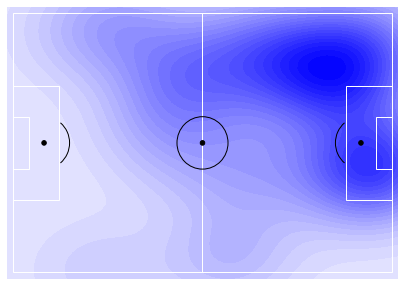

In [112]:
print_field_performance(events[ronaldo_id], 'blue')

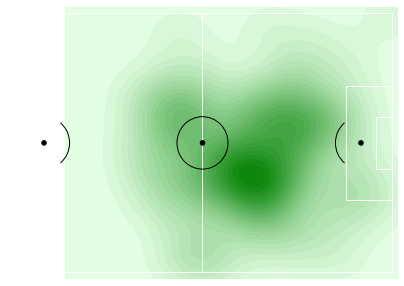

In [115]:
print_field_performance(events[messi_id], 'green')

###### II.

In this question we need to load information of Italian league

In [118]:
italy_matches = pd.read_json('./DS/matches_Italy.json')

In [119]:
italy_matches.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,524,"May 20, 2018 at 8:45:00 PM GMT+2",2018-05-20 18:45:00,Regular,38,"Lazio - Internazionale, 2 - 3","[{'refereeId': 377206, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",,3161,2576335
1,524,"May 20, 2018 at 8:45:00 PM GMT+2",2018-05-20 18:45:00,Regular,38,"Sassuolo - Roma, 0 - 1","[{'refereeId': 377255, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",MAPEI Stadium - Citt\u00e0 del Tricolore,3158,2576336
2,524,"May 20, 2018 at 6:00:00 PM GMT+2",2018-05-20 16:00:00,Regular,38,"Cagliari - Atalanta, 1 - 0","[{'refereeId': 377247, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",,3173,2576329
3,524,"May 20, 2018 at 6:00:00 PM GMT+2",2018-05-20 16:00:00,Regular,38,"Chievo - Benevento, 1 - 0","[{'refereeId': 377246, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",,3165,2576330
4,524,"May 20, 2018 at 6:00:00 PM GMT+2",2018-05-20 16:00:00,Regular,38,"Udinese - Bologna, 1 - 0","[{'refereeId': 377254, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",,3163,2576331


Having Match ID between Juventus and Napoli, ID of Jorginho and Pjanic.

In [120]:
juv_nap_match_id = get_match_id('Juventus', 'Napoli', '2018-04-22', 'Italy')
juv_nap_match_id

2576295

In [121]:
italy_events = pd.read_json('./DS/events_Italy.json')
jorginho_id = get_player_id('Jorge Luiz', 'Filho')
pjanic_id = get_player_id('Miralem', 'Pjani')
jorginho_id

21315

In [122]:
pjanic_id

20443

This is a function for extracting PASSES of a game for 2 players based on match ID, related dataset and ID of players.

In [123]:
def get_passes_from_events(events_dataset, match_id, player1_id, player2_id):
    
    event_types = ['pass']
    events = {player1_id:[], player2_id:[]}
    
    for i in range(len(events_dataset)):
        event_match_id = events_dataset['matchId'][i]
        
        if event_match_id == match_id:
            player_id = events_dataset['playerId'][i]
            
            if player1_id == player_id or player2_id == player_id:    
                event_type = events_dataset['eventName'][i]
    
                if event_type.lower() in event_types:
                    
                    positions = events_dataset['positions'][i]
                    match_period = events_dataset['matchPeriod'][i]
                    additional_tags = [e['id'] for e in italy_events['tags'][i]]
                    
                    start_position = [positions[0]['x'], 100 - positions[0]['y']]
                    ending_position = [positions[1]['x'], 100 - positions[1]['y']]
                    
                    successful = False
                    if 1801 in additional_tags:
                        successful = True
                    
                    positions = [start_position, ending_position, successful]
                    
                    positions[0][0] = 120 * positions[0][0] * 0.01
                    positions[1][0] = 120 * positions[1][0] * 0.01
                    
                    positions[0][1] = 80 * positions[0][1] * 0.01
                    positions[1][1] = 80 * positions[1][1] * 0.01
                    
                    events[player_id].append(positions)
                  
    return events

Extracting passes of Juv vs. Nap match for Jorginho and Pjanic.

In [124]:
juv_nap_passes = get_passes_from_events(italy_events, juv_nap_match_id, jorginho_id, pjanic_id)
juv_nap_passes

{21315: [[[56.4, 20.0], [74.4, 23.2], True],
  [[85.2, 44.800000000000004], [82.8, 46.4], False],
  [[56.4, 22.400000000000002], [73.2, 3.2], True],
  [[68.4, 57.6], [92.4, 53.6], True],
  [[73.2, 60.0], [88.8, 69.60000000000001], True],
  [[76.8, 61.6], [85.2, 64.0], True],
  [[67.2, 20.0], [87.60000000000001, 20.0], True],
  [[32.4, 24.0], [32.4, 35.2], False],
  [[31.2, 29.6], [34.800000000000004, 38.4], True],
  [[46.800000000000004, 26.400000000000002],
   [69.60000000000001, 15.200000000000001],
   True],
  [[39.6, 11.200000000000001], [49.2, 16.8], True],
  [[82.8, 60.0], [99.60000000000001, 72.8], True],
  [[76.8, 59.2], [67.2, 68.8], True],
  [[76.8, 11.200000000000001], [81.60000000000001, 5.6000000000000005], True],
  [[73.2, 8.0], [69.60000000000001, 17.6], True],
  [[62.4, 37.6], [60.0, 21.6], True],
  [[73.2, 58.4], [86.4, 76.0], True],
  [[72.0, 61.6], [88.8, 60.0], True],
  [[81.60000000000001, 50.4], [84.0, 41.6], True],
  [[74.4, 18.400000000000002], [90.0, 11.2000000

In [125]:
jorginho_passes = juv_nap_passes[jorginho_id]
pjanic_passes = juv_nap_passes[pjanic_id]
jorginho_passes

[[[56.4, 20.0], [74.4, 23.2], True],
 [[85.2, 44.800000000000004], [82.8, 46.4], False],
 [[56.4, 22.400000000000002], [73.2, 3.2], True],
 [[68.4, 57.6], [92.4, 53.6], True],
 [[73.2, 60.0], [88.8, 69.60000000000001], True],
 [[76.8, 61.6], [85.2, 64.0], True],
 [[67.2, 20.0], [87.60000000000001, 20.0], True],
 [[32.4, 24.0], [32.4, 35.2], False],
 [[31.2, 29.6], [34.800000000000004, 38.4], True],
 [[46.800000000000004, 26.400000000000002],
  [69.60000000000001, 15.200000000000001],
  True],
 [[39.6, 11.200000000000001], [49.2, 16.8], True],
 [[82.8, 60.0], [99.60000000000001, 72.8], True],
 [[76.8, 59.2], [67.2, 68.8], True],
 [[76.8, 11.200000000000001], [81.60000000000001, 5.6000000000000005], True],
 [[73.2, 8.0], [69.60000000000001, 17.6], True],
 [[62.4, 37.6], [60.0, 21.6], True],
 [[73.2, 58.4], [86.4, 76.0], True],
 [[72.0, 61.6], [88.8, 60.0], True],
 [[81.60000000000001, 50.4], [84.0, 41.6], True],
 [[74.4, 18.400000000000002], [90.0, 11.200000000000001], True],
 [[76.8, 16

This is a function for drawing match ground, heat map and passes of players based on positions and desired color where FALSE for all done passes and TRUE for accurate passes

In [126]:
def print_performance_with_arrows(positions, color, print_only_accurate=False):
    # Print the field
    fig=plt.figure() #set up the figures
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)
    plt.axis('off')
    # End drawing field
    
    # Heatmap
    x_positions = [p[0][0] for p in positions]
    y_positions = [p[0][1] for p in positions]
    
    sns.kdeplot(x_positions, y_positions, shade = "True", color = color, n_levels = 30)
       
    #Arrows
    for p in positions:
        is_accurate = p[2]
        
        start_x = p[0][0]
        start_y = p[0][1]
        
        end_x = p[1][0]
        end_y = p[1][1]
        
        if print_only_accurate:
            if is_accurate:
                ax.annotate("", xy = (end_x,end_y), xycoords = 'data',
                   xytext = (start_x, start_y), textcoords = 'data',
                   arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "green"),)
        else:
            ax.annotate("", xy = (end_x,end_y), xycoords = 'data',
                   xytext = (start_x, start_y), textcoords = 'data',
                   arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

    plt.show()

Ploting the results.

As it can be seen for PJANIC; almost all passes done correctly even passes near to opponent goalkeeper. But for Jorginho; He did very well in all regions of playground except passes which are done near the opponent goalkeeper.

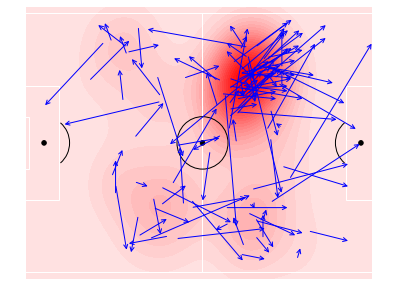

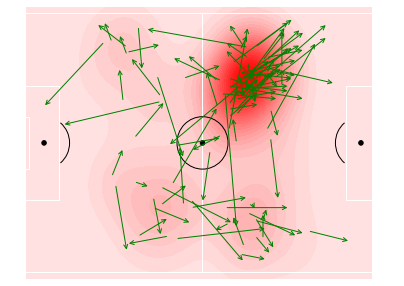

In [127]:
print_performance_with_arrows(jorginho_passes, 'red', print_only_accurate=False)
print_performance_with_arrows(jorginho_passes, 'red', print_only_accurate=True)

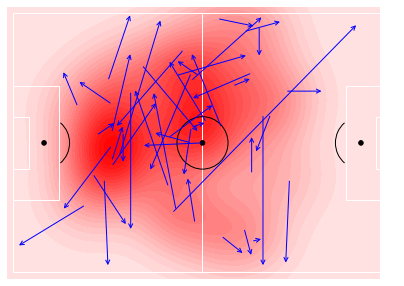

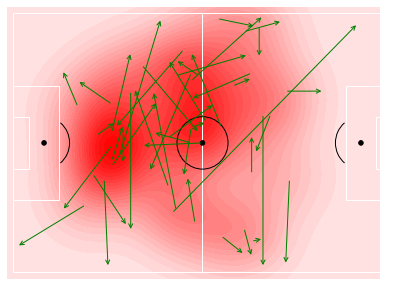

In [128]:
print_performance_with_arrows(pjanic_passes, 'red', print_only_accurate=False)
print_performance_with_arrows(pjanic_passes, 'red', print_only_accurate=True)